<a href="https://colab.research.google.com/github/maxnlee/DataSci112Final/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Are high-end restaurants clustered in certain areas or are they evenly distributed across Kyoto?
- Map restaurant and locations with price heatmaps (or cuisine?) COlORED MAP!
- K-means cluster analysis to identify the "price zones"
- Compare different districts
- ML: clustering to identify price and rating hotspots and predict

Does a higher price range correlate with better ratings, or are there affordable 'holes in the wall'?
-


1. where are most expensive restaurants located?

2. analyze % of restaurants that are Japanese through a heatmap
- relate to gentrification

3. analyze relationship between between price and rating - does a higher price range correlate with better ratings?
- map with scatterplot, regression analysis, or a box plot

4. potential sentiment analysis - what makes a restaurant highly rated?
- are japanese / international restaurants described differently?

need to extract
- [ ] lat/long data
- [ ] cuisines
- [ ] menu item and price
- [ ] number of ratings


In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import time
import pandas as pd
import numpy as np
import re
import os

def get_links():
  url_list = []
  descriptions = []
  num_pages = 60
  for i in range(1, num_pages + 1):
      url = f"https://tabelog.com/en/kyoto/rstLst/{i}/"
      url_list.append(url)

  restaurant_links = []
  restaurant_avg_price = []
  restaurant_ratings = np.zeros(20*num_pages)
  restaurant_cuisines = []
  headers = {"User-Agent": "Mozilla/5.0"}
  url_num = 0

  for url in url_list:
    url_num = url_num+1
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    for a_tag in soup.select("a.list-rst__rst-name-target"):
      link = a_tag.get("href")
      if link:
        restaurant_links.append(link)

    price_items = soup.find_all("li", class_="list-rst__info-item")

    avg_dinner_price = None
    for item in price_items:
      dinner_icon = item.find("i", attrs={"aria-label": "Average dinner price"})
      if dinner_icon:

        price_span = item.find("span", class_="c-rating-v3__val")
        if price_span:
          price_text = price_span.get_text(strip=True)

          price_numbers = re.findall(r'\d{1,3}(?:,\d{3})*', price_text)
          price_numbers = [int(p.replace(",", "")) for p in price_numbers]

          avg_dinner_price = sum(price_numbers) / len(price_numbers) if price_numbers else None
          restaurant_avg_price.append(avg_dinner_price)

    time.sleep(0.1)

  restaurant_df = pd.DataFrame({"link": restaurant_links, "avg price": restaurant_avg_price})
  return restaurant_df

In [ ]:
get_links()

,link,avg price
0,https://tabelog.com/en/kyoto/A2601/A260101/260...,12499.5
1,https://tabelog.com/en/kyoto/A2601/A260301/260...,8999.5
2,https://tabelog.com/en/kyoto/A2601/A260201/260...,5499.5
3,https://tabelog.com/en/kyoto/A2601/A260202/260...,17499.5
4,https://tabelog.com/en/kyoto/A2601/A260201/260...,8999.5
...,...,...
1195,https://tabelog.com/en/kyoto/A2601/A260202/260...,2499.5
1196,https://tabelog.com/en/kyoto/A2601/A260202/260...,4499.5
1197,https://tabelog.com/en/kyoto/A2601/A260401/260...,3499.5
1198,https://tabelog.com/en/kyoto/A2601/A260202/260...,4499.5


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
import aiohttp
import asyncio
import nest_asyncio

csv_url = 'https://raw.githubusercontent.com/maxnlee/DataSci112Final/main/restaurant_links.csv'
df_urls = pd.read_csv(csv_url)

cuisine_dict = {
    "italian": "Italian",
    "spanish": "Spanish",
    "french": "French",
    "spain": "Spanish",
    "cafe": "Cafe",
    "indian": "Indian",
    "chinese": "Chinese",
    "european": "European",
    "thai": "Thai",
    "korean": "Korean",
    "vietnamese": "Vietnamese",
    "japanese": "Japanese",
    "sushi": "Japanese",
    "tonkatsu": "Japanese",
    "yakitori": "Japanese",
    "yakiniku": "Japanese",
    "sukiyaki": "Japanese",
    "teppanyaki": "Japanese",
    "izakaya": "Japanese",
    "hot pot": "Asian",
    "pasta": "Italian",
    "udon": "Japanese",
    "soba": "Japanese",
    "curry": "Japanese",
    "ramen": "Japanese",
    "tempura": "Japanese",
    "hamburger": "American",
    "bar": "Bar",
    "restaurant": "Fusion",
    "beef": "Japanese"
}

def categorize_description(description):
    description = description.lower()

    for key, value in cuisine_dict.items():
        if key in description:
            return value
    return "Mixed"  # if no specific description, it's a mixed cuisine

def extract_primary_cuisine(cuisine_text):
    """Extracts the first word before 'Cuisine' or returns None if not found."""
    if pd.isna(cuisine_text):
        return None

    match = re.search(r'(\w+)\s+Cuisine', cuisine_text, re.IGNORECASE)

    if match:
        return match.group(1)
    return None

async def scrape_cuisine(session, url):
  headers = {"User-Agent": "Mozilla/5.0"}

  try:
    async with session.get(url, headers=headers) as response:
      if response.status != 200:
        return None
      text = await response.text()
      soup = BeautifulSoup(text, "html.parser")


      cuisine_section = soup.select("dd.rdheader-subinfo__item-text .linktree__parent-target-text")
      cuisines = [c.text.strip() for c in cuisine_section] if cuisine_section else "Mixed"

      return ", ".join(cuisines) if cuisines else None

  except Exception as e:
    print(f"⚠️ Error scraping {url}: {e}")
    return None

async def main(df):
    async with aiohttp.ClientSession() as session:
        tasks = []
        for url in df['link']:
            tasks.append(scrape_cuisine(session, url))

        results = await asyncio.gather(*tasks)

        df['description'] = results
        df['primary_cuisine'] = df['description'].apply(categorize_description)

        df['primary_cuisine'] = df.apply(
            lambda row: categorize_description(row['description'], cuisine_dict) if pd.isna(row['primary_cuisine']) else row['primary_cuisine'],
            axis=1
        )
        return df

def run_scraping(df):
  nest_asyncio.apply()
  loop = asyncio.get_event_loop()
  updated_df = loop.run_until_complete(main(df))

  updated_df.to_csv('restaurant_cuisines.csv', index=False)
  print("restaurant_cuisines.csv has been created successfully!")
  return updated_df

df_ret = run_scraping(df_urls)

In [ ]:
import concurrent.futures
import time
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

def fetch_lat_long(link):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    try:
        response = requests.get(link, headers=headers, timeout=5)
        soup = BeautifulSoup(response.text, 'html.parser')

        map_img = soup.find("img", class_="js-map-lazyload")

        lat, long = 0, 0
        if map_img:
            map_url = map_img["data-original"]
            match = re.search(r'center=(-?\d+\.\d+),(-?\d+\.\d+)', map_url)
            if match:
                lat, long = match.group(1), match.group(2)

        return link, lat, long

    except Exception as e:
        print(f"Error fetching {link}: {e}")
        return link, 0, 0

def get_lat_long(links, batch_size=10):
    df_loc = pd.DataFrame(columns=["link", "lat", "long"])

    for i in range(0, len(links), batch_size):
        batch = links[i:i+batch_size]

        with concurrent.futures.ThreadPoolExecutor(max_workers=batch_size) as executor:
            results = list(executor.map(fetch_lat_long, batch))

        batch_df = pd.DataFrame(results, columns=["link", "lat", "long"])
        df_loc = pd.concat([df_loc, batch_df], ignore_index=True)

        time.sleep(0.1)

    return df_loc


In [ ]:
import pandas as pd

csv_url = 'https://raw.githubusercontent.com/maxnlee/DataSci112Final/main/restaurant_links.csv'

df = pd.read_csv(csv_url)

print(df.head())

if 'cuisine' in df.columns:
    cuisines = df['cuisine'].astype(str).str.split(', ').explode().dropna().unique()
    cuisine_df = pd.DataFrame(cuisines, columns=['cuisine'])

    print(cuisine_df.head())

    cuisine_csv = 'unique_cuisines.csv'
    cuisine_df.to_csv(cuisine_csv, index=False)

    print("'unique_cuisines.csv' has been saved")

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import concurrent.futures

def fetch_lat_long(link):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    try:
        response = requests.get(link, headers=headers, timeout=5)
        soup = BeautifulSoup(response.text, 'html.parser')

        map_img = soup.find("img", class_="js-map-lazyload")

        lat, long = 0, 0
        if map_img:
            map_url = map_img["data-original"]
            match = re.search(r'center=(-?\d+\.\d+),(-?\d+\.\d+)', map_url)
            if match:
                lat, long = match.group(1), match.group(2)

        return link, lat, long

    except Exception as e:
        print(f"Error fetching {link}: {e}")
        return link, 0, 0

def get_lat_long(links):
    df_loc = pd.DataFrame(columns=["link", "lat", "long"])

    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        results = list(executor.map(fetch_lat_long, links))

    df_loc = pd.DataFrame(results, columns=["link", "lat", "long"])
    return df_loc


Now done with cleaning and I'm going to try to plot question 1 now. What is the median price of restaurants, by location?

In [ ]:
import pandas as pd
import folium
import numpy as np
from shapely.geometry import box


links_df = pd.read_csv("https://github.com/maxnlee/DataSci112Final/raw/main/restaurant_links.csv")
loc_df = pd.read_csv("https://github.com/maxnlee/DataSci112Final/raw/main/loc.csv")

loc_df['link'] = loc_df['link'].astype(str)
combined_df = loc_df.join(links_df.set_index('link'), on='link', how='inner', lsuffix='_caller', rsuffix='_other')
combined_df = combined_df[['link', 'lat', 'long', 'avg price']]


grid_size = 0.017 #approx 1 mile squared
min_restaurants = 5

min_lat, max_lat = combined_df["lat"].min(), combined_df["lat"].max()
min_long, max_long = combined_df["long"].min(), combined_df["long"].max()

lat_bins = np.arange(min_lat, max_lat, grid_size)
long_bins = np.arange(min_long, max_long, grid_size)

kyoto_center = [35.0116, 135.7681]
m = folium.Map(location=kyoto_center, zoom_start=13)

def price_color(price):
    if price < 5000:
        return "green"
    elif price < 7500:
        return "orange"
    else:
        return "red"

for lat in lat_bins:
    for lon in long_bins:
        mask = (
            (combined_df["lat"] >= lat) & (combined_df["lat"] < lat + grid_size) &
            (combined_df["long"] >= lon) & (combined_df["long"] < lon + grid_size)
        )

        num_restaurants = mask.sum()

        avg_price = combined_df.loc[mask, "avg price"].median()
        if not np.isnan(avg_price) and num_restaurants >= min_restaurants:
            color = price_color(avg_price)
            folium.Rectangle(
                bounds=[(lat, lon), (lat + grid_size, lon + grid_size)],
                color=color,
                fill=True,
                fill_opacity=0.5,
                popup=f"Median Price: ¥{int(avg_price)}. Number of restaurants: {mask.sum()}",
            ).add_to(m)

m.save("kyoto_median_restaurant_price_heatmap.html")
m


This graph explores Kyoto's wealth, particularly on and around the "Kamo" river. Home to many of Japan's oldest and most symbolic cultural landmarks, Kyoto has also become a common tourist destination. The areas of higher wealth are also much more common places for wealthy foreigners to visit. Restaurant prices are a good indicator of this trend.

In [ ]:
import folium
from folium.plugins import HeatMap
import numpy as np
from scipy.spatial.distance import cdist

cuisine_df = pd.read_csv("https://github.com/maxnlee/DataSci112Final/raw/main/restaurant_cuisines.csv")
loc_df = pd.read_csv("https://github.com/maxnlee/DataSci112Final/raw/main/loc.csv")

loc_df['link'] = loc_df['link'].astype(str)
combined_df = loc_df.join(cuisine_df.set_index('link'), on='link', how='inner', lsuffix='_caller', rsuffix='_other')
combined_df = combined_df[['link', 'lat', 'long', 'primary_cuisine']]
combined_df

kyoto_neighborhoods = {
    "Gion": {"latitude": 35.0036, "longitude": 135.7785},
    "Shimogyo": {"latitude": 35.0116, "longitude": 135.7584},
    "Kamo River Area": {"latitude": 35.0222, "longitude": 135.7630},
    "Kamigamo": {"latitude": 35.0480, "longitude": 135.7546},
    "Kyoto Imperial Palace Area": {"latitude": 35.0270, "longitude": 135.7726},
    "Higashiyama": {"latitude": 35.9943, "longitude": 135.7831},
    "Nijo": {"latitude": 35.0110, "longitude": 135.7413},
    "Nishiki Market": {"latitude": 35.0055, "longitude": 135.7599},
    "Kyoto Station Area": {"latitude": 34.9855, "longitude": 135.7584},
    "Kiyomizu": {"latitude": 34.9949, "longitude": 135.7850},
    "Fushimi": {"latitude": 34.8983, "longitude": 135.7777},
    "Sagano": {"latitude": 35.0126, "longitude": 135.6662},
}


combined_df['is_japanese'] = combined_df['primary_cuisine'].apply(lambda x: 1 if x == 'Japanese' else 0)

combined_df['lat_grid'] = (combined_df['lat'] // 0.01) * 0.01
combined_df['lon_grid'] = (combined_df['long'] // 0.01) * 0.01

grid_counts = combined_df.groupby(['lat_grid', 'lon_grid']).agg(
    total_restaurants=('link', 'count'),
    japanese_restaurants=('is_japanese', 'sum')
).reset_index()

grid_counts['percent_japanese'] = (grid_counts['japanese_restaurants'] / grid_counts['total_restaurants']) * 100
overall_mean_japanese = (combined_df['is_japanese'].sum() / len(combined_df)) * 100
grid_coords = grid_counts[['lat_grid', 'lon_grid', 'percent_japanese']]

def find_percent_japanese_in_neighborhood(neighborhood, grid_counts):
    coords = kyoto_neighborhoods[neighborhood]
    lat, lon = coords['latitude'], coords['longitude']

    distances = cdist([[lat, lon]], grid_counts[['lat_grid', 'lon_grid']].values, metric='euclidean')
    closest_idx = np.argmin(distances)
    return grid_counts.iloc[closest_idx]['percent_japanese']


def find_closest_non_zero_neighborhood(lat, lon, neighborhoods, grid_counts):
    min_distance = float('inf')
    closest_neighborhood = None
    closest_percentage = 0
    for name, coords in neighborhoods.items():
        distance = np.sqrt((lat - coords['latitude'])**2 + (lon - coords['longitude'])**2)
        percent_japanese = find_percent_japanese_in_neighborhood(name, grid_counts)
        if distance < min_distance and percent_japanese > 0:
            min_distance = distance
            closest_neighborhood = name
            closest_percentage = percent_japanese

    return closest_neighborhood, closest_percentage

m = folium.Map(location=[35.00900000, 135.76710849713783], zoom_start=13)

for neighborhood, coords in kyoto_neighborhoods.items():
    closest_neighborhood, closest_percentage = find_closest_non_zero_neighborhood(coords['latitude'], coords['longitude'], kyoto_neighborhoods, grid_coords)
    folium.Marker(
        location=[coords['latitude'], coords['longitude']],
        popup=f"{neighborhood}: {closest_percentage:.2f}% Japanese",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

combined_df['closest_grid_percentage'] = combined_df.apply(lambda row: find_closest_non_zero_neighborhood(row['lat'], row['long'], kyoto_neighborhoods, grid_coords)[1], axis=1) # Access the second element (percentage) from the tuple
mean_closest_grid_percentage = combined_df['closest_grid_percentage'].mean()

heat_data = [[row['lat_grid'], row['lon_grid'], row['percent_japanese']] for index, row in grid_counts.iterrows()]

HeatMap(
    heat_data,
    min_opacity=0.2,
    radius=30,
    blur=20,
    gradient={'0': 'blue', '0.3': 'blue', '0.4': 'green', '0.5': 'yellow', '0.6': 'red'}
).add_to(m)

print(f"Closest grid percentage: {mean_closest_grid_percentage}. Overall percentage: {overall_mean_japanese}")

m

#m.save("kyoto_japanese_cuisine_heatmap.html")



Closest grid percentage: 57.91374094508298. Overall percentage: 61.71809841534612


If we place each of these 13 important cultural landmarks and regions onto a map, we find a trend. And if we also color code Kyoto according to the percentage of Japanese restaurants in an area, we find that many of these landmarks are located near areas of relatively lower Japanese cuisine density. Red represents 60% Japanese, yellow: 50% and green 40%. Also, if we find the closest neighborhood for each of these landmarks, then take the mean of these neighborhoods, we find that the percentage of Japanese restaurants near these landmarks goes from a nation-wide average of 61.7% down to 57.9%. That's a big difference!

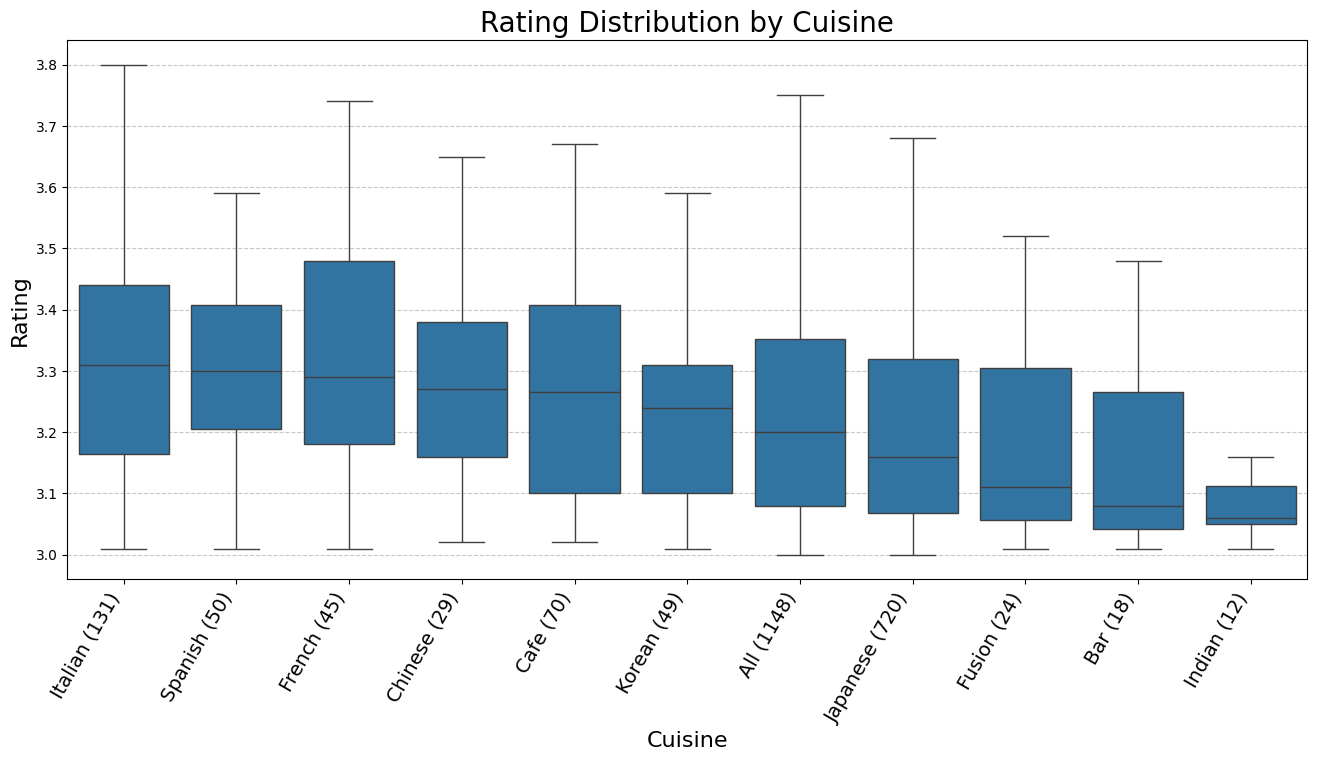

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("https://github.com/maxnlee/DataSci112Final/raw/main/merged.csv")  # Adjust path if needed
df["primary_cuisine"] = df["primary_cuisine"].replace({"Mixed": "Fusion"})

# Remove invalid ratings and convert to float
df = df[df["rating"].notna()]
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df = df[df["rating"].notna()]

# Count occurrences per cuisine
cuisine_counts = df["primary_cuisine"].value_counts()

# Filter cuisines with at least 5 reviews (optional, avoids single-point issues)
valid_cuisines = cuisine_counts[cuisine_counts >= 10].index
df = df[df["primary_cuisine"].isin(valid_cuisines)]

cuisine_means = df.groupby("primary_cuisine")["rating"].median()

# Add "All Cuisines" as an integrated category
all_cuisines_mean = df["rating"].median()
all_cuisines_count = len(df)
cuisine_means["All"] = all_cuisines_mean  # Add overall mean rating
cuisine_counts["All"] = all_cuisines_count  # Add total count

# Sort cuisines in descending order
sorted_cuisines = cuisine_means.sort_values(ascending=False).index.tolist()

# Update dataset with new categorical sorting
df["primary_cuisine"] = pd.Categorical(df["primary_cuisine"], categories=sorted_cuisines, ordered=True)

# Create "All Cuisines" category for visualization
df_all = df.copy()
df_all["primary_cuisine"] = "All"
df_combined = pd.concat([df, df_all])  # Merge datasets


# Create x-axis labels with count of reviews (bold for "All Cuisines")
cuisine_labels = [
    f"{cuisine} ({cuisine_counts[cuisine]})" if cuisine != "All" else f"{cuisine} ({cuisine_counts[cuisine]})"
    for cuisine in sorted_cuisines
]

# Plot Boxplot
plt.figure(figsize=(16, 7))
sns.boxplot(x="primary_cuisine", y="rating", data=df_combined, showfliers=False, order=sorted_cuisines)

# Formatting
plt.title("Rating Distribution by Cuisine", fontsize=20)
plt.xlabel("Cuisine", fontsize=16)
plt.ylabel("Rating", fontsize=16)
plt.xticks(ticks=range(len(cuisine_labels)), labels=cuisine_labels, rotation=60, ha="right", fontsize=14)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show plot
plt.show()


It is clear that Italian food is rated higher than other types of cuisines. Japanese food is much lower on the list, which suggests that foreign culture have a heavy influence on Japan.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


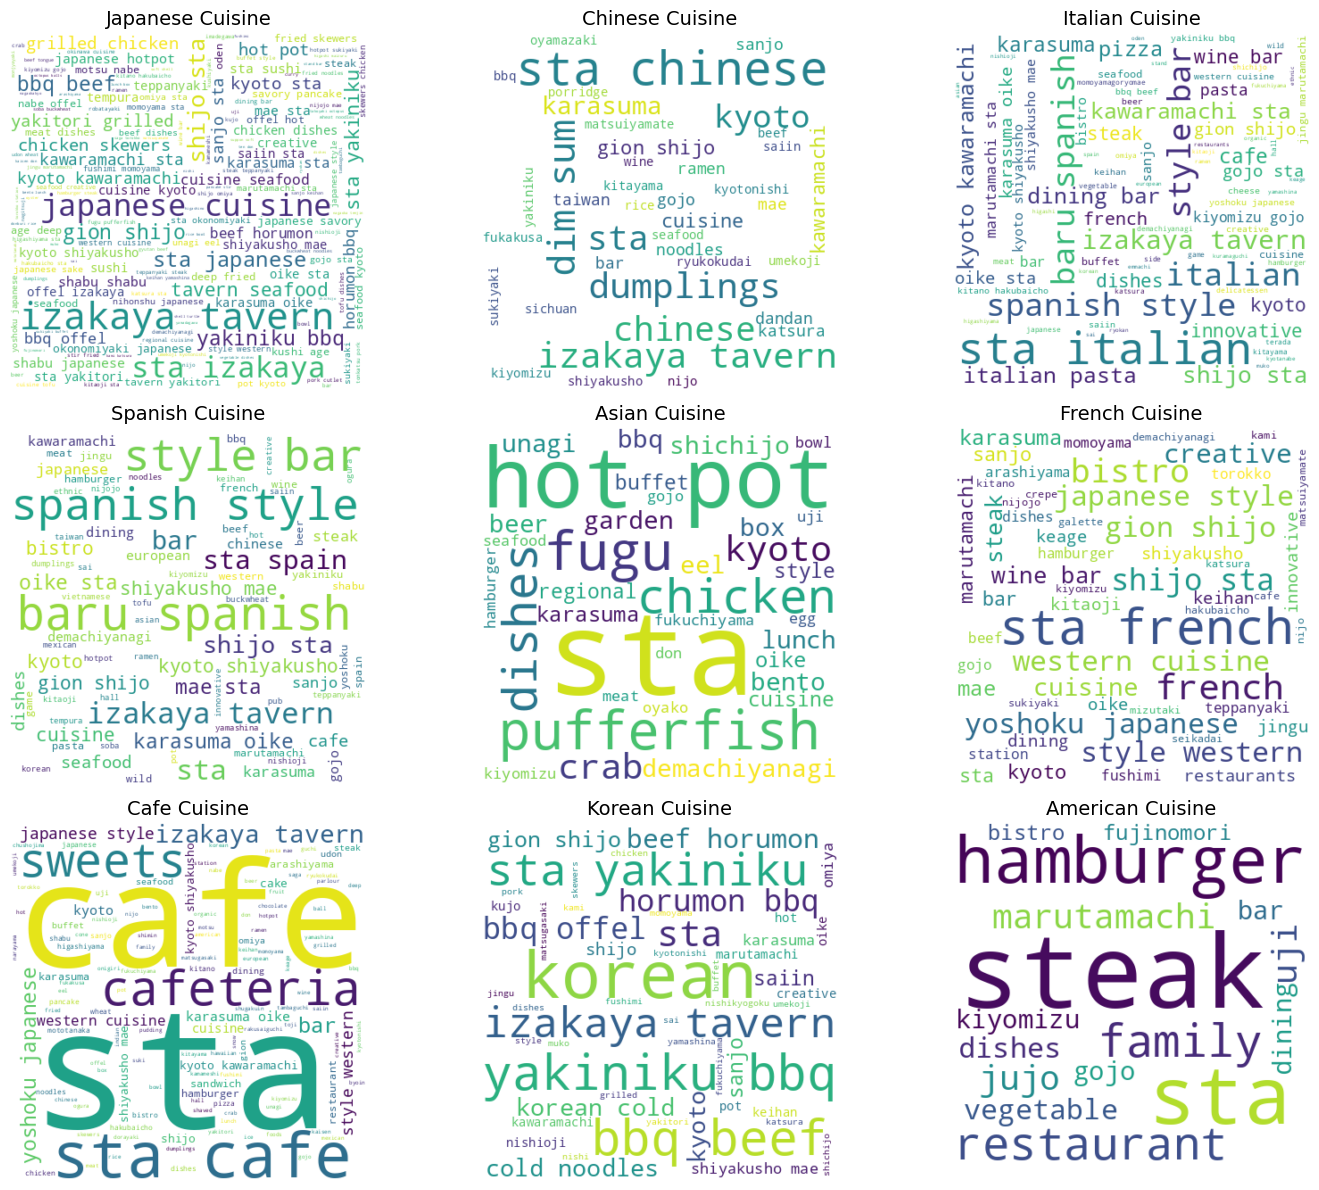

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
import string

# Download NLTK stopwords
nltk.download('stopwords')

# Load dataset
df = pd.read_csv("https://github.com/maxnlee/DataSci112Final/raw/main/merged.csv")

# Preprocess text: Lowercase, remove stopwords, and punctuation
stop_words = set(stopwords.words("english")) | set(string.punctuation)
cuisine_texts = defaultdict(str)

for _, row in df.dropna(subset=["primary_cuisine", "description"]).iterrows():
    cuisine = row["primary_cuisine"]
    words = row["description"].lower().split()
    words = [word.strip(string.punctuation) for word in words if word not in stop_words]
    cuisine_texts[cuisine] += " " + " ".join(words)

# Generate Word Clouds for each cuisine type
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))  # Adjust grid size based on number of cuisines
axes = axes.flatten()

for i, (cuisine, text) in enumerate(cuisine_texts.items()):
    if i >= len(axes):  # Prevent excess subplots
        break
    wordcloud = WordCloud(width=400, height=400, background_color="white", colormap="viridis").generate(text)

    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"{cuisine} Cuisine", fontsize=14)

plt.tight_layout()
plt.show()
